# Imports and Definitions

In [15]:
import sys
sys.path.append('../')

In [16]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.6)
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from utils.data_utils import preprocess_and_normalize_energy_data, parse_codecarbon_output
from sklearn.linear_model import LinearRegression
from utils.experiments_utils import split_data_set, fit_model, apply_data_transforms, test_model
%load_ext autoreload
%autoreload 2
SEED = 1234

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
param_cols = ['batch_size','input_size']

# ReLU
## Data Loading

In [18]:
d1_relu = parse_codecarbon_output(
    '../data/activations/01_relu_raw.csv',
    False,
    ('../data/activations/01_relu-slurm-log.out','relu',False,3)
)
print("dataset shape:", d1_relu.shape)
d1_relu["test"] = True
d2_relu = parse_codecarbon_output(
    '../data/activations/00_relu-raw.csv',
    False,
    ('../data/activations/00_activations-slurm-log.out','relu',True,3)
)
d2_relu["test"] = False
print("dataset shape:", d2_relu.shape)
data_unnormalized_relu = pd.concat([d1_relu,d2_relu])
print("dataset shape before aggregation: ", data_unnormalized_relu.shape)

Dropped observations with the following indices: [115, 169, 286, 368, 456, 565, 761, 791, 953, 1127, 1154, 1295, 1462]
dataset shape: (1487, 27)
Dropped observations with the following indices: [36, 37, 38, 210, 211, 212, 234, 235, 236, 378, 379, 380, 543, 544, 545, 636, 637, 638, 834, 835, 836, 1041, 1042, 1043, 1206, 1207, 1208, 1236, 1237, 1238, 1371, 1372, 1373, 1431, 1432, 1433]
dataset shape: (1464, 28)
dataset shape before aggregation:  (2951, 28)


In [19]:
data_relu = preprocess_and_normalize_energy_data(data_unnormalized_relu, param_cols, aggregate=True)
data_relu.head()

Final shape of data set: (988, 19)


batch_size  input_size   duration  emissions  emissions_rate  cpu_power  \
0         511     4964807  33.348036   0.001094        0.032864  49.231577   
1         325     1325323  30.436965   0.000998        0.032780  75.151260   
2         374     4613506  30.878238   0.001040        0.033658  48.407276   
3         218     4327579  30.186662   0.000965        0.031969  74.965870   
4         143     3873946  30.478427   0.001024        0.033599  73.076756   

   gpu_power  ram_power  cpu_energy  gpu_energy  ram_energy  energy_consumed  \
0  30.569333     288.75    0.000103    0.000044    0.000400         0.000547   
1  30.690667     288.75    0.000017    0.000007    0.000066         0.000090   
2  30.610000     288.75    0.000071    0.000030    0.000283         0.000384   
3  30.471000     288.75    0.000039    0.000016    0.000145         0.000200   
4  30.495000     288.75    0.000024    0.000010    0.000093         0.000126   

   cpu_count  gpu_count  ram_total_size  rep_no          macs  forward_passes  \
0        2.0        1.0           770.0     2.0  2.537016e+09        6.666667   
1        2.0        1.0           770.0     2.0  4.307300e+08       36.666667   
2        2.0        1.0           770.0     2.0  1.725451e+09        9.000000   
3        2.0        1.0           770.0     2.0  9.434122e+08       16.000000   
4        2.0        1.0           770.0     2.0  5.539743e+08       27.000000   

   test  
0   1.0  
1   1.0  
2   1.0  
3   1.0  
4   1.0

## Modeling
### Feature Set: Parameters

In [26]:
dfs = split_data_set(data_relu, param_cols+['macs'], SEED, verbose=True)
transformers_dict = {
    "x_preprocessors": [PolynomialFeatures(degree=2, interaction_only=True)],
    "y_preprocessor": MinMaxScaler()
}
dfs, transformers = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Number of observations: train/691, val/198 and test-set/99
Average R2 Cross-Validation Score: 0.981 (± 0.004)
Average MSE Cross-Validation: -1.036e-03 (± 2.031e-04)
Validation R2 Score: 0.979
Validation MSE: 1.007e-03


/home/jupyter-iec_binhnguyen/Nas/darts_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Test R2 Score: 0.9807
Test MSE: 9.207e-04


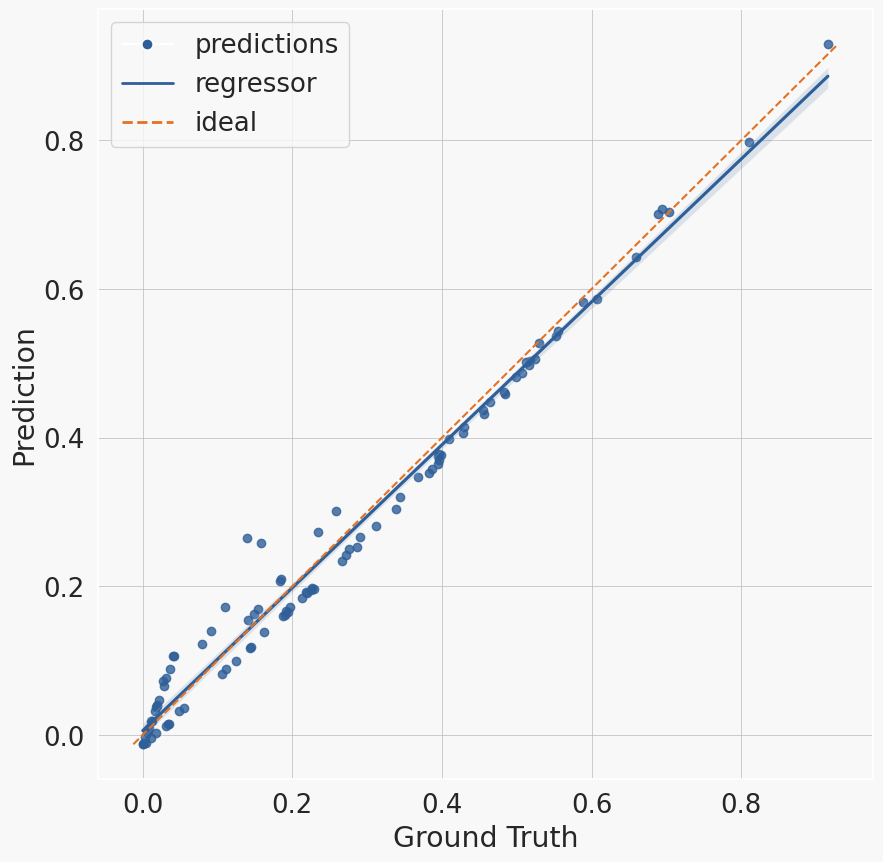

In [27]:
_, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [29]:
import joblib
import pandas as pd
# Lưu model và transformer
joblib.dump(model, 'linear_model.pkl')
joblib.dump(transformers, 'transformer.pkl')

# Tải model và transformer
model = joblib.load('linear_model.pkl')
transformer = joblib.load('transformer.pkl')

# Chuẩn bị dữ liệu đầu vào mới
import pandas as pd

sample_df = pd.DataFrame([{
    "batch_size": 4,
    "attributed": "activation",
    "sub_attributed": "relu",
    "input_size": 131,
    "output_size": 1372,
    "macs": 1046
}])

# samples=data[:1][param_cols].copy()


# sampless, param_cols_with_log = compute_log_transformed_features(samples, param_cols)
# sampless["macs"]=sample_df["macs"]
sampless=sample_df[param_cols+['macs']]
# sampless['macs'] = 4194304
# samples['macs']=data['macs'][:1].copy()
# Áp dụng transformer
sampless = transformer['x_preprocessors'][0].transform(sampless)

# Dự đoán
y_pred = model.predict(sampless)
y_pred = transformer["y_preprocessor"].inverse_transform(y_pred.reshape(-1, 1))
# y_pred = max(0, y_pred[0]) 
print("Predicted:", y_pred)


Predicted: [[-1.34158108e-06]]


## Modeling
### Feature Set: MACs

In [23]:
dfs = split_data_set(data_relu, ['macs'], SEED, verbose=True)
transformers_dict = {
    "x_preprocessors": None,
    "y_preprocessor": MinMaxScaler()
}
dfs, transformers = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Number of observations: train/691, val/198 and test-set/99
Average R2 Cross-Validation Score: 0.981 (± 0.005)
Average MSE Cross-Validation: -1.046e-03 (± 2.284e-04)
Validation R2 Score: 0.979
Validation MSE: 1.030e-03


/home/jupyter-iec_binhnguyen/Nas/darts_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [24]:
import joblib
import pandas as pd
# Lưu model và transformer
joblib.dump(model, 'linear_model.pkl')
joblib.dump(transformers, 'transformer.pkl')

# Tải model và transformer
model = joblib.load('linear_model.pkl')
transformer = joblib.load('transformer.pkl')

# Chuẩn bị dữ liệu đầu vào mới
import pandas as pd

sample_df = pd.DataFrame([{
    "batch_size": 4,
    "attributed": "activation",
    "sub_attributed": "relu",
    "input_size": 131,
    "output_size": 12,
    "macs": 1046
}])

# samples=data[:1][param_cols].copy()


# sampless, param_cols_with_log = compute_log_transformed_features(samples, param_cols)
# sampless["macs"]=sample_df["macs"]
sampless=sample_df[param_cols]
# sampless['macs'] = 4194304
# samples['macs']=data['macs'][:1].copy()
# Áp dụng transformer
# sampless = transformer['x_preprocessors'][0].transform(sampless)
sampless=sample_df['macs'].values.reshape(-1, 1)

# Dự đoán
y_pred = model.predict(sampless)
y_pred = transformer["y_preprocessor"].inverse_transform(y_pred.reshape(-1, 1))
# y_pred = max(0, y_pred[0]) 
print("Predicted:", y_pred)


Predicted: [[-2.13346121e-06]]


/home/jupyter-iec_binhnguyen/Nas/darts_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Test R2 Score: 0.9812
Test MSE: 8.998e-04


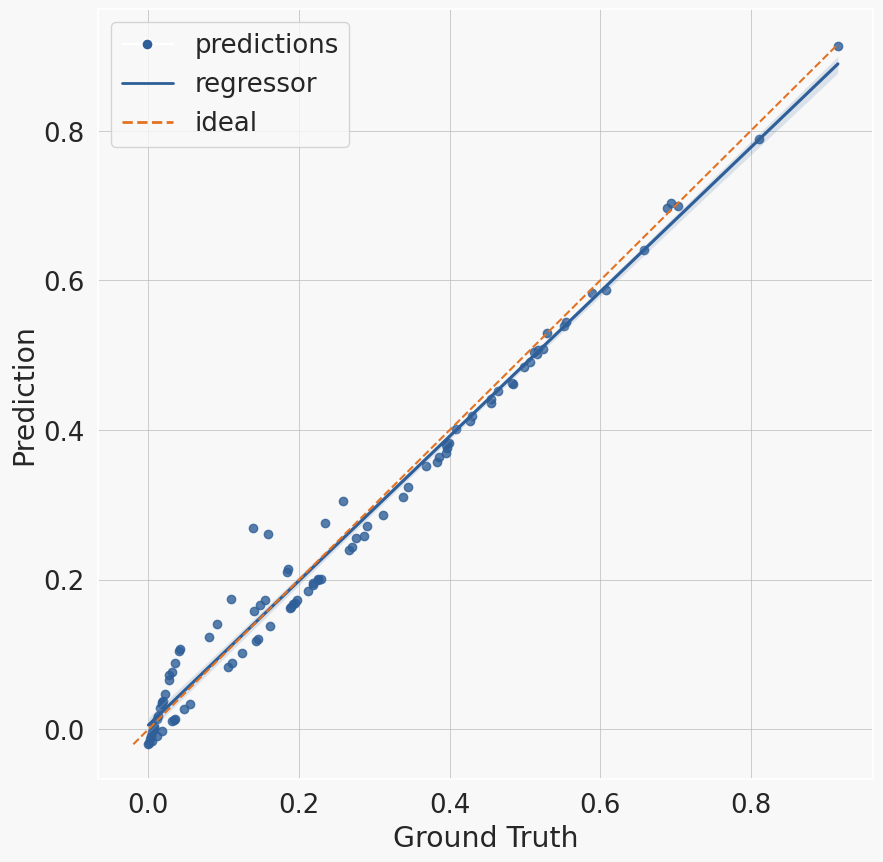

In [9]:
_, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

# TanH
## Data Loading

In [15]:
%cd ..

/home/jupyter-iec_binhnguyen/Nas/darts/loopup_create/cnn/dl_energy_estimator/experiments


In [16]:
data_unnormalized_tanh = parse_codecarbon_output(
    '../data/activations/00_tanh-raw.csv',
    False,
    ('../data/activations/00_activations-slurm-log.out','tanh',True,3)
)

Dropped observations with the following indices: [138, 139, 140, 195, 196, 197, 303, 304, 305, 396, 397, 398, 462, 463, 464, 786, 787, 788, 948, 949, 950, 1107, 1108, 1109, 1272, 1273, 1274]


In [17]:
print("dataset shape before aggregation: ", data_unnormalized_tanh.shape)
data_tanh = preprocess_and_normalize_energy_data(data_unnormalized_tanh, param_cols, aggregate=True)
data_tanh.head()

dataset shape before aggregation:  (1473, 27)
Final shape of data set: (491, 18)


batch_size  input_size   duration  emissions  emissions_rate  cpu_power  \
0         353     1326998  30.550957   0.001123        0.036837  76.592422   
1         341     4892172  32.817825   0.001073        0.032708  75.291991   
2         111     4566314  30.134626   0.001112        0.036898  76.599624   
3         441     1087035  30.380539   0.001120        0.036885  75.816491   
4         156      690781  30.064531   0.001355        0.045069  77.737987   

   gpu_power  ram_power  cpu_energy    gpu_energy  ram_energy  \
0  29.856333     288.75    0.000017  6.695451e-06    0.000068   
1  29.623333     288.75    0.000076  3.004319e-05    0.000290   
2  29.869333     288.75    0.000019  7.329654e-06    0.000086   
3  29.481333     288.75    0.000012  4.736639e-06    0.000050   
4  29.561333     288.75    0.000002  5.615547e-07    0.000008   

   energy_consumed  cpu_count  gpu_count  ram_total_size  rep_no  macs  \
0         0.000092        2.0        1.0           770.0     2.0   0.0   
1         0.000396        2.0        1.0           770.0     2.0   0.0   
2         0.000112        2.0        1.0           770.0     2.0   0.0   
3         0.000068        2.0        1.0           770.0     2.0   0.0   
4         0.000010        2.0        1.0           770.0     2.0   0.0   

   forward_passes  
0       52.333333  
1        9.000000  
2       46.333333  
3       71.666667  
4      440.000000

## Modeling
### Feature Set: Parameters

In [18]:
dfs = split_data_set(data_tanh,['macs'], SEED)
transformers_dict = {
    "x_preprocessors": [PolynomialFeatures(degree=2, interaction_only=False)],
    "y_preprocessor": MinMaxScaler()
}
dfs, transformers = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Average R2 Cross-Validation Score: -0.052 (± 0.073)
Average MSE Cross-Validation: -5.850e-02 (± 1.041e-02)
Validation R2 Score: -0.004
Validation MSE: 6.799e-02


/home/jupyter-iec_binhnguyen/Nas/darts_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Test R2 Score: 0.9761
Test MSE: 1.412e-03


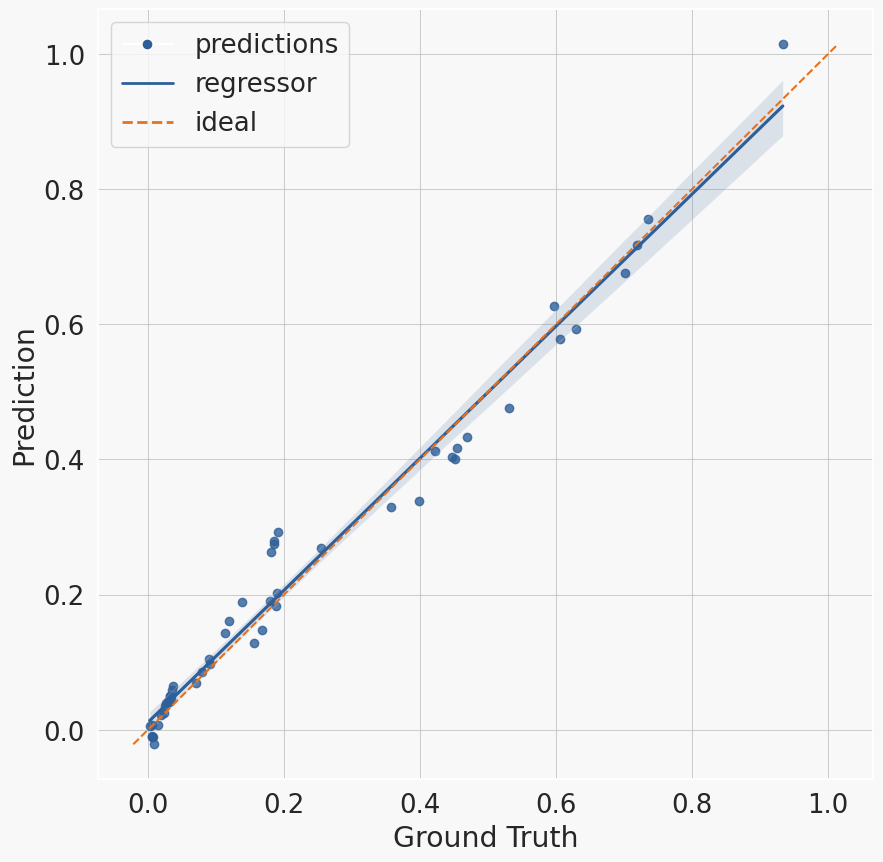

In [40]:
_, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [41]:
import pickle

with open("./activation/tanh/linear_test_conv_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Mô hình Linear Regression đã được lưu vào linear_model.pkl")
with open("./activation/tanh/x_transformer.pkl", "wb") as f:
    pickle.dump(transformers["x_preprocessors"][0], f)

with open("./activation/tanh/y_transformer.pkl", "wb") as f:
    pickle.dump(transformers["y_preprocessor"], f)

print("✅ Transformers đã được lưu thành công.")

✅ Mô hình Linear Regression đã được lưu vào linear_model.pkl
✅ Transformers đã được lưu thành công.


### Notes
- standardscaler has no effect

In [ ]:
transformers

# Sigmoid
## Data Loading

In [19]:
data_unnormalized_sigmoid = parse_codecarbon_output(
    '../data/activations/00_sigmoid-raw.csv',
    False,
    ('../data/activations/00_activations-slurm-log.out','sigmoid',True,3)
)

Dropped observations with the following indices: [21, 22, 23, 120, 121, 122, 183, 184, 185, 345, 346, 347, 516, 517, 518, 828, 829, 830, 996, 997, 998, 1110, 1111, 1112, 1161, 1162, 1163, 1305, 1306, 1307, 1479, 1480, 1481]


In [20]:
print("dataset shape before aggregation: ", data_unnormalized_sigmoid.shape)
data_sigmoid = preprocess_and_normalize_energy_data(data_unnormalized_sigmoid, param_cols, aggregate=True)
data_sigmoid.head()

dataset shape before aggregation:  (1467, 27)
Final shape of data set: (489, 18)


batch_size  input_size   duration  emissions  emissions_rate  cpu_power  \
0         506     4505379  35.223038   0.001152        0.032715  75.323322   
1         219     1266149  30.255887   0.001000        0.033037  78.446300   
2         352     3366962  30.672796   0.001125        0.036669  73.302046   
3         435      624213  30.178774   0.001238        0.041040  75.634361   
4         494     2160900  31.276623   0.001023        0.032715  74.445486   

   gpu_power  ram_power  cpu_energy  gpu_energy  ram_energy  energy_consumed  \
0  29.871333     288.75    0.000123    0.000048    0.000467         0.000638   
1  29.714000     288.75    0.000006    0.000002    0.000021         0.000028   
2  29.602667     288.75    0.000064    0.000025    0.000284         0.000374   
3  29.724667     288.75    0.000005    0.000002    0.000026         0.000034   
4  29.840000     288.75    0.000058    0.000023    0.000219         0.000300   

   cpu_count  gpu_count  ram_total_size  rep_no  macs  forward_passes  
0        2.0        1.0           770.0     2.0   0.0        6.000000  
1        2.0        1.0           770.0     2.0   0.0      117.333333  
2        2.0        1.0           770.0     2.0   0.0       10.000000  
3        2.0        1.0           770.0     2.0   0.0      122.000000  
4        2.0        1.0           770.0     2.0   0.0       11.333333

## Modeling
### Feature Set: Parameters

In [21]:
dfs = split_data_set(data_sigmoid, ['macs'], SEED)
transformers_dict = {
    "x_preprocessors": [PolynomialFeatures(degree=2, interaction_only=True)],
    "y_preprocessor": MinMaxScaler()
}
dfs, transformers = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Average R2 Cross-Validation Score: -0.029 (± 0.059)
Average MSE Cross-Validation: -6.110e-02 (± 1.415e-02)
Validation R2 Score: -0.000
Validation MSE: 5.043e-02


/home/jupyter-iec_binhnguyen/Nas/darts_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Test R2 Score: -0.0898
Test MSE: 8.645e-02


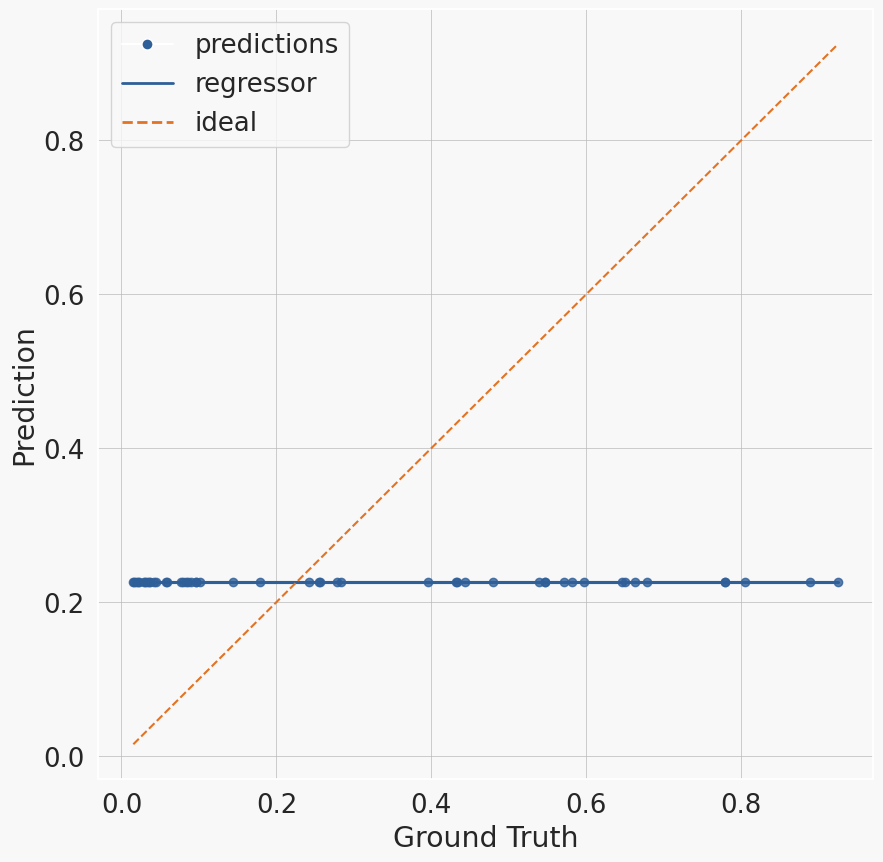

In [22]:
_, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [48]:
import pickle

with open("./activation/sig/linear_test_conv_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Mô hình Linear Regression đã được lưu vào linear_model.pkl")
with open("./activation/sig/x_transformer.pkl", "wb") as f:
    pickle.dump(transformers["x_preprocessors"][0], f)

with open("./activation/sig/y_transformer.pkl", "wb") as f:
    pickle.dump(transformers["y_preprocessor"], f)

print("✅ Transformers đã được lưu thành công.")

✅ Mô hình Linear Regression đã được lưu vào linear_model.pkl
✅ Transformers đã được lưu thành công.


# Softmax
## Data Loading

In [52]:
data_unnormalized_softmax = parse_codecarbon_output(
    '../data/activations/00_softmax-raw.csv',
    False,
    ('../data/activations/00_activations-slurm-log.out','softmax',True,3)
)

Dropped observations with the following indices: [72, 73, 74, 93, 94, 95, 255, 256, 257, 273, 274, 275, 417, 418, 419, 1215, 1216, 1217, 1242, 1243, 1244]


In [53]:
print("dataset shape before aggregation: ", data_unnormalized_softmax.shape)
data_softmax = preprocess_and_normalize_energy_data(data_unnormalized_softmax, param_cols, aggregate=True)
data_softmax.head()

dataset shape before aggregation:  (1479, 27)
Final shape of data set: (493, 18)


batch_size  input_size   duration  emissions  emissions_rate  cpu_power  \
0         415     1673479  30.401512   0.001120        0.036864  74.622881   
1         150      528017  30.119854   0.001237        0.041087  75.758087   
2         352     3105482  32.593072   0.001069        0.032813  76.397953   
3          50     3883956  30.218480   0.001117        0.036972  78.031386   
4          91     2167276  30.187220   0.001237        0.040999  77.379755   

   gpu_power  ram_power  cpu_energy  gpu_energy  ram_energy  energy_consumed  \
0  29.727333     288.75    0.000042    0.000016    0.000174         0.000233   
1  29.712333     288.75    0.000003    0.000001    0.000014         0.000018   
2  29.986667     288.75    0.000077    0.000030    0.000288         0.000395   
3  29.637333     288.75    0.000008    0.000003    0.000033         0.000043   
4  29.831333     288.75    0.000008    0.000003    0.000038         0.000048   

   cpu_count  gpu_count  ram_total_size  rep_no  macs  forward_passes  
0        2.0        1.0           770.0     2.0   0.0       16.666667  
1        2.0        1.0           770.0     2.0   0.0      230.000000  
2        2.0        1.0           770.0     2.0   0.0        9.000000  
3        2.0        1.0           770.0     2.0   0.0       85.666667  
4        2.0        1.0           770.0     2.0   0.0       85.000000

## Modeling
### Feature Set: Parameters

In [54]:
dfs = split_data_set(data_softmax, param_cols, SEED)
transformers_dict = {
    "x_preprocessors": [PolynomialFeatures(degree=2, interaction_only=True)],
    "y_preprocessor": MinMaxScaler()
}
dfs, transformers = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Average R2 Cross-Validation Score: 0.989 (± 0.004)
Average MSE Cross-Validation: -5.671e-04 (± 1.599e-04)
Validation R2 Score: 0.993
Validation MSE: 4.760e-04


/home/jupyter-iec_binhnguyen/Nas/darts_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Test R2 Score: 0.9913
Test MSE: 4.972e-04


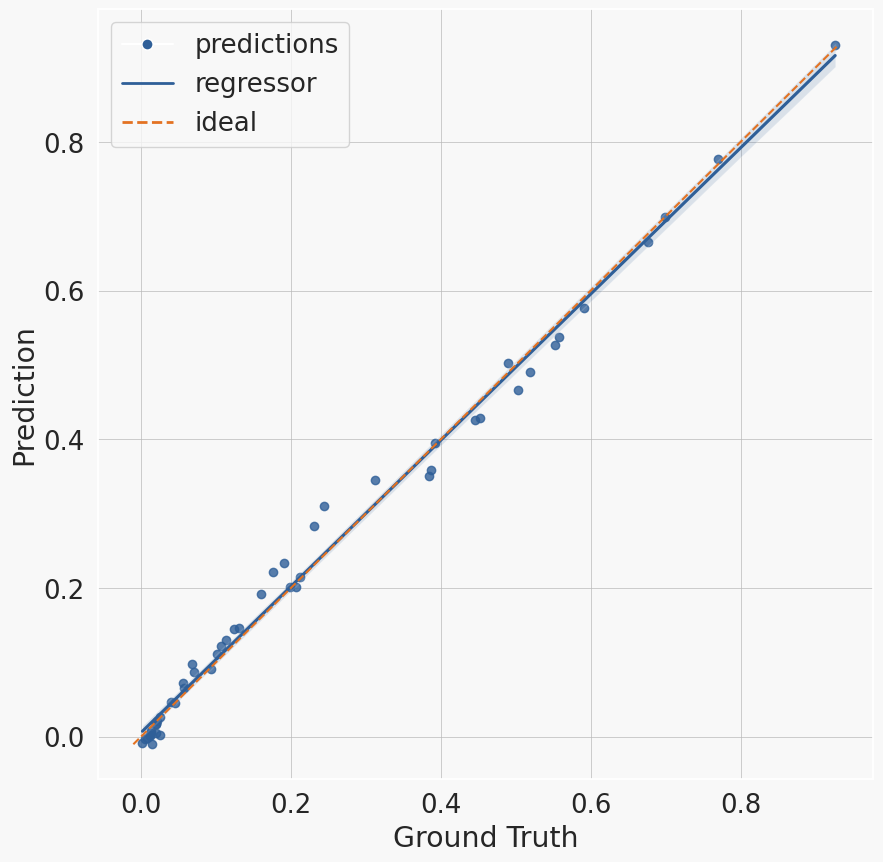

In [55]:
_, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [56]:
import pickle

with open("./activation/sof/linear_test_conv_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Mô hình Linear Regression đã được lưu vào linear_model.pkl")
with open("./activation/sof/x_transformer.pkl", "wb") as f:
    pickle.dump(transformers["x_preprocessors"][0], f)

with open("./activation/sof/y_transformer.pkl", "wb") as f:
    pickle.dump(transformers["y_preprocessor"], f)

print("✅ Transformers đã được lưu thành công.")

✅ Mô hình Linear Regression đã được lưu vào linear_model.pkl
✅ Transformers đã được lưu thành công.
